In [44]:
import os, sys
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE 
import pickle

from sklearn.neighbors import KNeighborsClassifier     #KNN
from sklearn.linear_model import LogisticRegression    #Logistic Regression
from sklearn.tree import DecisionTreeClassifier        #Decision Tree
from sklearn.ensemble import RandomForestClassifier    #Random Forest
from sklearn.neural_network import MLPClassifier       #Neural Network
from sklearn.svm import SVC                            #SVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
#import graphviz

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

plt.style.use('bmh')
seed = 1234

# Directories

In [79]:
data_dir = "../data"
results_dir = "../output"

In [80]:
for d in [results_dir]:
      try: os.makedirs(d)
      except: pass

# Load data

In [11]:
df = pd.read_pickle(os.path.join(data_dir, 'df_clean'))

In [12]:
df.head()

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7.0,8.0,3.0,7.0,4.0,5.0,7.0,8.0,2.0,1
1,1,1107684,6.0,10.0,5.0,5.0,4.0,10.0,6.0,10.0,1.0,1
2,2,691628,8.0,6.0,4.0,10.0,10.0,1.0,3.0,5.0,1.0,1
3,3,1226612,7.0,5.0,6.0,3.0,3.0,8.0,7.0,4.0,1.0,1
4,4,1142706,5.0,10.0,10.0,10.0,6.0,10.0,6.0,5.0,2.0,1


In [16]:
features = df.columns.drop(['Index', 'ID', 'Class'])
labels = 'Class'

In [17]:
X = df[features]
y = df[labels]

In [20]:
y

0        1
1        1
2        1
3        1
4        1
        ..
15850    1
15851    1
15852    1
15853    1
15854    1
Name: Class, Length: 15760, dtype: int64

# Data splitting

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = seed)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = .2,
                                                  random_state=seed)

In [38]:
print('Original train dataset shape %s' % Counter(y_train))
print('Original test dataset shape %s' % Counter(y_test))

Original train dataset shape Counter({1: 9808, 0: 278})
Original test dataset shape Counter({1: 3060, 0: 92})


# Fix imbalanced data with SMOTE

When use any sampling technique ( specifically synthetic) you divide your data first and then apply synthetic sampling on the training data only. After you train you use the testing set ( which contains only original samples) to evaluate. The risk if you use your strategy is to have the original sample in training ( testing) and the synthetic sample ( that was created based on this original sample) in the testing ( training) set.

In [39]:
sm = SMOTE(random_state=seed)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [40]:
print('Resampled train dataset shape %s' % Counter(y_train_res))

Resampled train dataset shape Counter({1: 9808, 0: 9808})


# Plots

In [47]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# Modeling 

## Logistic Regression

Accuracy on the training set: 0.991
Accuracy on the testing set: 0.996
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        92
           1       1.00      1.00      1.00      3060

    accuracy                           1.00      3152
   macro avg       0.95      0.98      0.96      3152
weighted avg       1.00      1.00      1.00      3152



/home/bithika/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


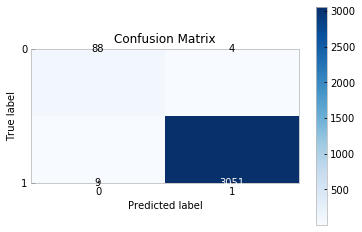

In [46]:
log_reg = LogisticRegression()
log_reg.fit(X_train_res, y_train_res)

# Predict the labels of the test data: y_pred
y_pred = log_reg.predict(X_test)

print('Accuracy on the training set: {:.3f}'.format(log_reg.score(X_train_res, y_train_res)))
print('Accuracy on the testing set: {:.3f}'.format(log_reg.score(X_test,y_test)))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

#  Random Forests

In [49]:
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [50]:
# Predict the labels of the test data: y_pred
y_pred = forest.predict(X_test)

Accuracy on trained data:  1.0
Accuracy on validation data:  0.9988104678826328
Accuracy on test data:  0.9980964467005076
************************************************************
 
************************************************************
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        92
           1       1.00      1.00      1.00      3060

    accuracy                           1.00      3152
   macro avg       0.98      0.98      0.98      3152
weighted avg       1.00      1.00      1.00      3152

************************************************************
 
************************************************************


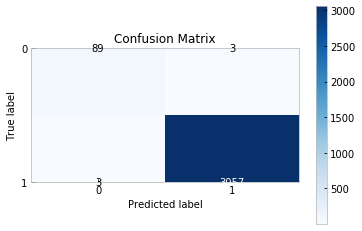

In [70]:
print("Accuracy on trained data: ", forest.score(X_train,y_train))
print("Accuracy on validation data: ", forest.score(X_val,y_val))
print("Accuracy on test data: ", forest.score(X_test,y_test))
print("************************************************************")
print(" ")
print("************************************************************")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print("************************************************************")
print(" ")
print("************************************************************")

### Feature Importance


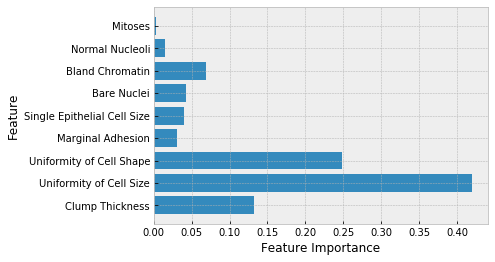

In [60]:
n_feature= features.shape[0]
plt.barh(range(n_feature), forest.feature_importances_, align='center')
plt.yticks(np.arange(n_feature), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [82]:
pickle.dump(forest, open(os.path.join(results_dir,'Trained_Forest_CV'), 'wb'))

Mitroses seems to be least important

#  SVM (Support Vector Machine)

In [71]:
svm= SVC()
svm.fit(X_train, y_train)

print('acc on train dataset: {:.3f}'.format(svm.score(X_train,y_train)))
print('acc on test dataset: {:.3f}'.format(svm.score(X_test,y_test)))

acc on train dataset: 1.000
acc on test dataset: 0.998


/home/bithika/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [72]:
# Predict the labels of the test data: y_pred
y_pred = svm.predict(X_test)

Accuracy on trained data:  0.9999008526670633
Accuracy on validation data:  0.9976209357652657
Accuracy on test data:  0.9984137055837563
************************************************************
 
************************************************************
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        92
           1       1.00      1.00      1.00      3060

    accuracy                           1.00      3152
   macro avg       1.00      0.97      0.99      3152
weighted avg       1.00      1.00      1.00      3152

************************************************************
 
************************************************************


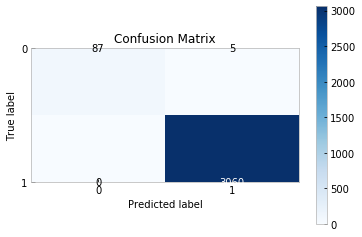

In [73]:
print("Accuracy on trained data: ", svm.score(X_train,y_train))
print("Accuracy on validation data: ", svm.score(X_val,y_val))
print("Accuracy on test data: ", svm.score(X_test,y_test))
print("************************************************************")
print(" ")
print("************************************************************")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print("************************************************************")
print(" ")
print("************************************************************")

In [ ]:
# not sure how to do feature importance here